In [64]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import calendar
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

# Network analysis for Uber drive data

## Data process

In [2]:
data1 = pd.read_csv('uber_drive_data.csv')
data1 = data1.drop(data1.index[len(data1)-1])  # Remove unnecessary summary information
data1.head()

,START_DATE*,END_DATE*,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016 21:11,1/1/2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016 1:25,1/2/2016 1:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,1/2/2016 20:25,1/2/2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016 17:31,1/5/2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016 14:42,1/6/2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   START_DATE*  1155 non-null   object 
 1   END_DATE*    1155 non-null   object 
 2   CATEGORY*    1155 non-null   object 
 3   START*       1155 non-null   object 
 4   STOP*        1155 non-null   object 
 5   MILES*       1155 non-null   float64
 6   PURPOSE*     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [4]:
# There are some missing values in 'PURPOSE*', replace them with Others to simplify analysis
data1.loc[data1['PURPOSE*'].isna(), 'PURPOSE*'] = 'Others'
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   START_DATE*  1155 non-null   object 
 1   END_DATE*    1155 non-null   object 
 2   CATEGORY*    1155 non-null   object 
 3   START*       1155 non-null   object 
 4   STOP*        1155 non-null   object 
 5   MILES*       1155 non-null   float64
 6   PURPOSE*     1155 non-null   object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


## Data analysis

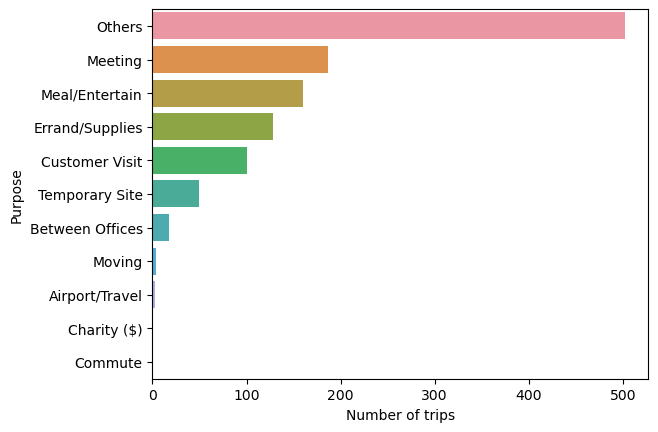

In [5]:
# Analysis the purposes of each trip
trip_count = data1['PURPOSE*'].value_counts().tolist()
trip_purpose= data1['PURPOSE*'].value_counts().index.tolist()
trip_info = list(zip(trip_purpose, trip_count))     # Match the trip purpose with the corresponding count and combine them into a list
trip_info = pd.DataFrame(trip_info, columns=['PURPOSE','COUNT'])

ax = sns.barplot(x='COUNT',y='PURPOSE',data=trip_info)
ax.set(xlabel='Number of trips', ylabel='Purpose')
plt.show()

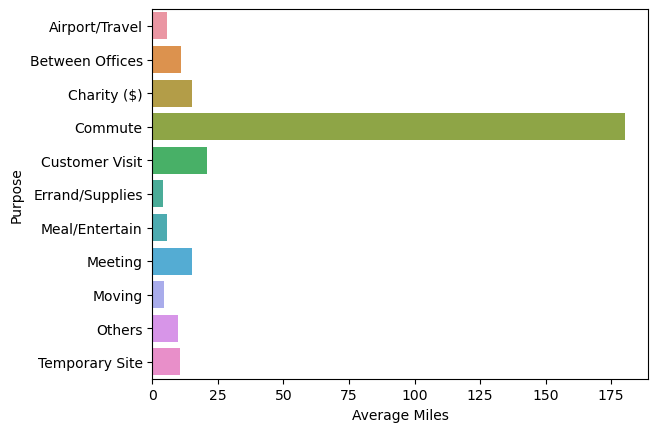

In [6]:
trip_summary = data1.groupby('PURPOSE*')['MILES*'].mean().reset_index()
trip_summary.columns = ['PURPOSE', 'AVG_MILES']  # Rename the columns for clarity
ax = sns.barplot(x='AVG_MILES', y='PURPOSE', data=trip_summary)
ax.set(xlabel='Average Miles', ylabel='Purpose')
plt.show()

In [7]:
# Extract date and time
start_list = [info.split(' ') for info in data1['START_DATE*'].tolist()]
stop_list = [info.split(' ') for info in data1['END_DATE*'].tolist()]

start_df  = pd.DataFrame(start_list,columns=['Start_Date','Start_Time'])
end_df  = pd.DataFrame(stop_list,columns=['End_Date','End_Time'])

sub_data = data1[['CATEGORY*','START*','STOP*','MILES*','PURPOSE*']]
start_end_info = pd.concat([start_df,end_df],axis=1)

trips = pd.concat([start_end_info,sub_data],axis=1)
trips.head(5)

,Start_Date,Start_Time,End_Date,End_Time,CATEGORY*,START*,STOP*,MILES*,PURPOSE*
0,1/1/2016,21:11,1/1/2016,21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,1/2/2016,1:25,1/2/2016,1:37,Business,Fort Pierce,Fort Pierce,5.0,Others
2,1/2/2016,20:25,1/2/2016,20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,1/5/2016,17:31,1/5/2016,17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,1/6/2016,14:42,1/6/2016,15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


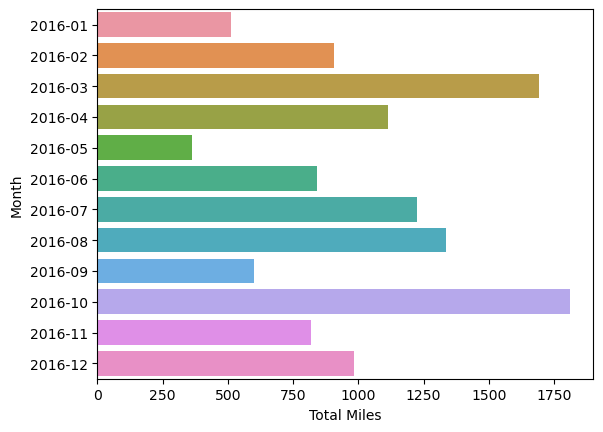

In [8]:
# Calculate total mileage for each month
trips_per_month = trips.groupby('Start_Date').sum()
trips_per_month['Month']=pd.to_datetime(trips_per_month.index.tolist())  # Convert index to datetime format
trips_per_month['Month']= trips_per_month['Month'].dt.to_period("M")     # Convert datetime format to month period format
trips_per_month= trips_per_month.sort_values(by= 'Month',ascending=True) # Sort by month so that it can be displayed in chronological order when plotting
 
total_miles_per_month= trips_per_month.groupby('Month').sum()
total_miles_per_month['MONTH']=total_miles_per_month.index.tolist()
total_miles_per_month['MONTH']=total_miles_per_month['MONTH'].astype(str) 
ax = sns.barplot(x='MILES*',y='MONTH',data=total_miles_per_month)
ax.set(xlabel='Total Miles', ylabel='Month')
plt.show()

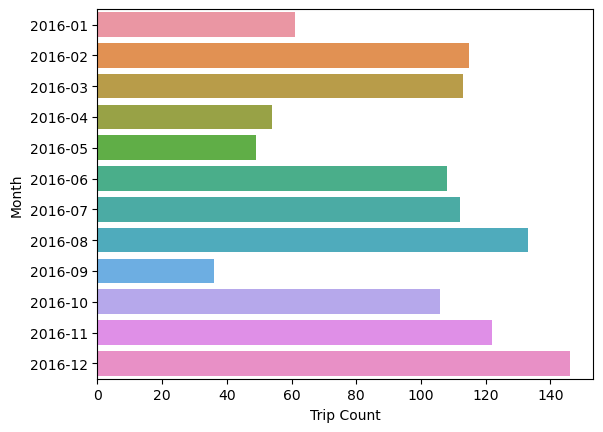

In [116]:
trips['Start_Date'] = pd.to_datetime(trips['Start_Date'])
trips['Month'] = trips['Start_Date'].dt.to_period('M')
trips_per_month = trips.groupby('Month').size()
trips_per_month_df = trips_per_month.reset_index(name='Trip Count')

sns.barplot(x='Trip Count', y='Month', data=trips_per_month_df)
ax.set(xlabel='Total Counts', ylabel='Month')
plt.show()

In [9]:
g = nx.from_pandas_edgelist(trips,source='START*',target='STOP*',
                            edge_attr=['Start_Date','Start_Time','End_Date','End_Time','CATEGORY*','MILES*','PURPOSE*'])

print("Number of nodes:", g.number_of_nodes())
print("Number of edges:", g.number_of_edges())
average_degree = sum(dict(g.degree()).values()) / len(g)
print("Average degree:", average_degree)

Number of nodes: 209
Number of edges: 280
Average degree: 2.6794258373205744


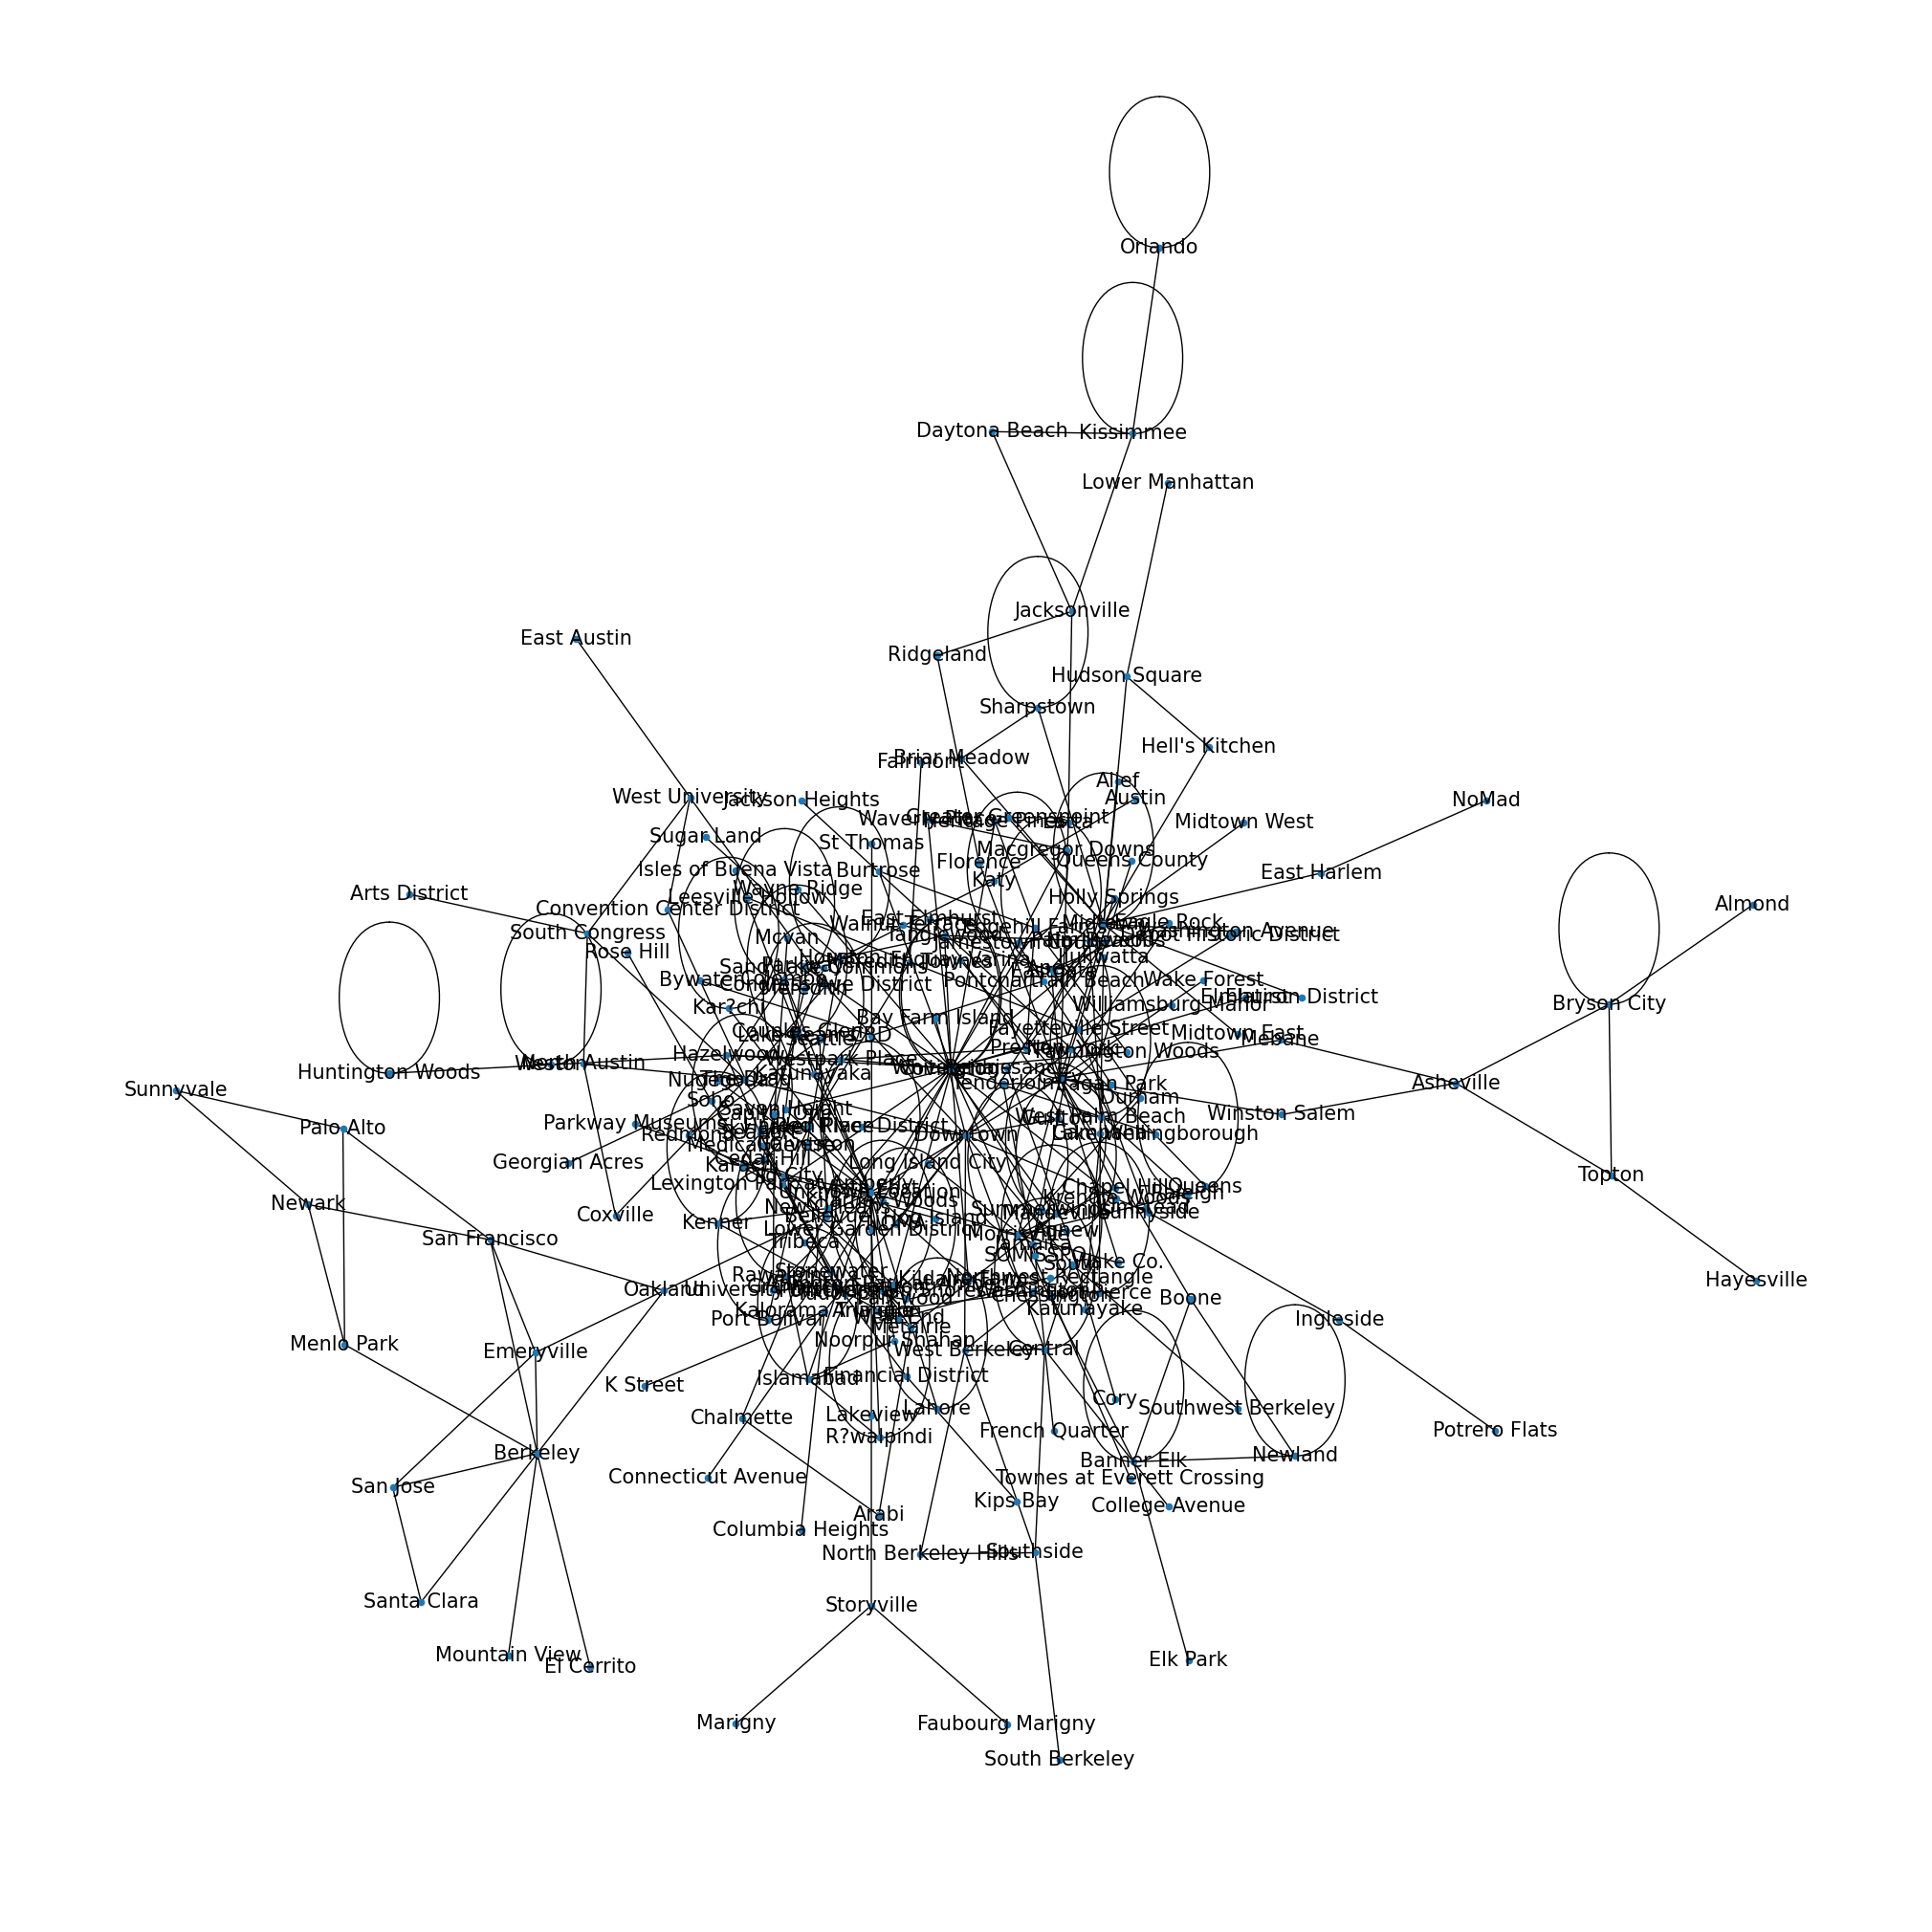

In [120]:
plt.figure(figsize=(20,20)) 
# nx.draw_circular(g,with_labels=True,node_size=50)
pos1 = nx.kamada_kawai_layout(g)  # You can try different layouts like nx.spring_layout(G)
nx.draw(g, pos1, with_labels=True, node_size=20, font_size=15)
plt.show()

In [11]:
location=[]
degree=[]
for node in g:
    location.append(node)
    degree.append(g.degree(node))

degree_dist_list = list (zip(location,degree))
degree_dist = pd.DataFrame(degree_dist_list, columns=['Location','Degree'])
degree_dist.sort_values(by='Degree', ascending=False)

,Location,Degree
25,Whitebridge,26
3,Cary,18
50,Unknown Location,15
9,Midtown,14
18,Downtown,12
...,...,...
89,Vista East,1
86,Isles of Buena Vista,1
81,Greater Greenspoint,1
79,Washington Avenue,1


# Network analysis for Uber boston data

## Data Process

In [122]:
data2 = pd.read_csv('uber_data_boston.csv')
data2.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


Notice that there are 57 columns in this dataset. Many of them might be useless. So drop the extra columns and work with the rest.

In [13]:
dropped_cols = [ 'apparentTemperature', 'precipIntensity' , 'humidity', 'windSpeed', 'apparentTemperatureHigh',
                 'dewPoint', 'precipIntensityMax', 'apparentTemperatureMax', 'cloudCover', 'moonPhase',
                 'windGustTime', 'visibility', 'temperatureHighTime' , 'apparentTemperatureHighTime',
                 'apparentTemperatureLow' , 'apparentTemperatureLowTime', 'temperatureMinTime' , 'temperatureMaxTime',
                 'apparentTemperatureMin', 'apparentTemperatureMinTime', 'apparentTemperatureMaxTime',
                 'windBearing' , 'sunriseTime', 'uvIndex' , 'visibility.1',  'ozone', 'sunsetTime', 'uvIndexTime']

data2 = data2.drop(dropped_cols, axis=1)

In [14]:
data2.sample(5)

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,long_summary,precipProbability,windGust,temperatureHigh,temperatureLow,temperatureLowTime,icon,pressure,temperatureMin,temperatureMax
102167,798268cc-b6a5-42b6-849a-8cf36b41f6c0,1.544787e+09,11,14,12,2018-12-14 11:25:11,America/New_York,North End,Financial District,Uber,...,Partly cloudy throughout the day.,0.00,4.06,46.63,40.78,1544832000,partly-cloudy-night,1034.02,27.21,46.63
98893,07e746be-f74c-4e96-a0d4-669dff21ff13,1.543301e+09,6,27,11,2018-11-27 06:48:22,America/New_York,Beacon Hill,Northeastern University,Lyft,...,Light rain in the morning.,1.00,12.67,47.55,33.10,1543402800,rain,996.34,35.36,47.55
330882,1496242c-9fa5-4e14-a1dc-2348c0bb3be6,1.543790e+09,22,2,12,2018-12-02 22:28:04,America/New_York,Back Bay,Fenway,Uber,...,Light rain until evening.,0.03,4.37,50.78,44.71,1543816800,cloudy,1002.91,35.89,50.78
498553,27e09268-43c8-4af5-b0bb-1755896820aa,1.544742e+09,23,13,12,2018-12-13 23:00:08,America/New_York,North End,West End,Uber,...,Partly cloudy throughout the day.,0.00,2.62,33.81,27.05,1544781600,cloudy,1035.00,17.91,33.81
242205,7e027a23-eb58-45f2-a946-a15bf4b8851d,1.543905e+09,6,4,12,2018-12-04 06:28:00,America/New_York,Theatre District,Boston University,Uber,...,Partly cloudy throughout the day.,0.00,9.09,38.80,19.63,1544007600,cloudy,1004.30,25.65,42.70


In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  693071 non-null  object 
 1   timestamp           693071 non-null  float64
 2   hour                693071 non-null  int64  
 3   day                 693071 non-null  int64  
 4   month               693071 non-null  int64  
 5   datetime            693071 non-null  object 
 6   timezone            693071 non-null  object 
 7   source              693071 non-null  object 
 8   destination         693071 non-null  object 
 9   cab_type            693071 non-null  object 
 10  product_id          693071 non-null  object 
 11  name                693071 non-null  object 
 12  price               637976 non-null  float64
 13  distance            693071 non-null  float64
 14  surge_multiplier    693071 non-null  float64
 15  latitude            693071 non-nul

In [16]:
# Drop missing values
print(data2.isnull().sum())
print(data2.isnull().sum().sum())
data2 = data2.dropna()

id                        0
timestamp                 0
hour                      0
day                       0
month                     0
datetime                  0
timezone                  0
source                    0
destination               0
cab_type                  0
product_id                0
name                      0
price                 55095
distance                  0
surge_multiplier          0
latitude                  0
longitude                 0
temperature               0
short_summary             0
long_summary              0
precipProbability         0
windGust                  0
temperatureHigh           0
temperatureLow            0
temperatureLowTime        0
icon                      0
pressure                  0
temperatureMin            0
temperatureMax            0
dtype: int64
55095


In [17]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637976 entries, 0 to 693070
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  637976 non-null  object 
 1   timestamp           637976 non-null  float64
 2   hour                637976 non-null  int64  
 3   day                 637976 non-null  int64  
 4   month               637976 non-null  int64  
 5   datetime            637976 non-null  object 
 6   timezone            637976 non-null  object 
 7   source              637976 non-null  object 
 8   destination         637976 non-null  object 
 9   cab_type            637976 non-null  object 
 10  product_id          637976 non-null  object 
 11  name                637976 non-null  object 
 12  price               637976 non-null  float64
 13  distance            637976 non-null  float64
 14  surge_multiplier    637976 non-null  float64
 15  latitude            637976 non-null  fl

## Data Analysis

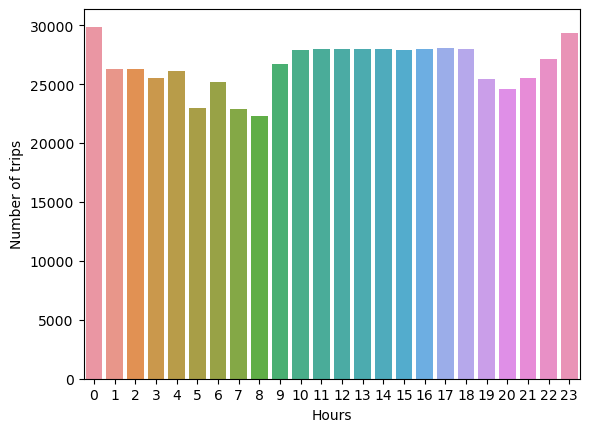

In [39]:
hour_count = data2['hour'].value_counts().tolist()
hour = data2['hour'].value_counts().index.tolist()
hour_info = list(zip(hour, hour_count))
hour_info = pd.DataFrame(hour_info, columns=['hour', 'count'])

ax = sns.barplot(x='hour', y='count', data=hour_info)
ax.set(xlabel='Hours', ylabel='Number of trips')
plt.show()

Text(0.5, 1.0, 'Number of trips Vs Months')

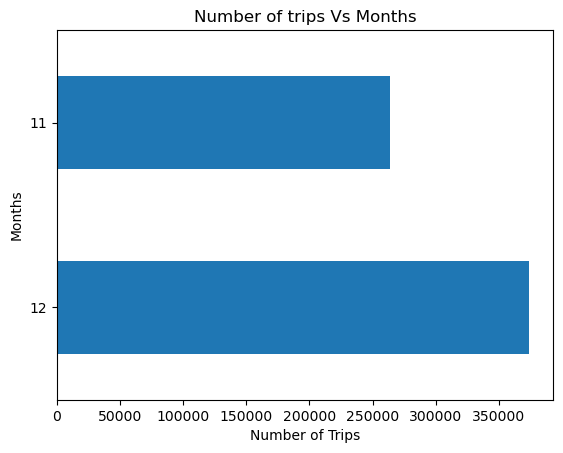

In [89]:
months = data2[ 'month' ].value_counts()
months.plot(kind='barh')
plt.xlabel('Number of Trips')
plt.ylabel('Months' )
plt.title( 'Number of trips Vs Months')

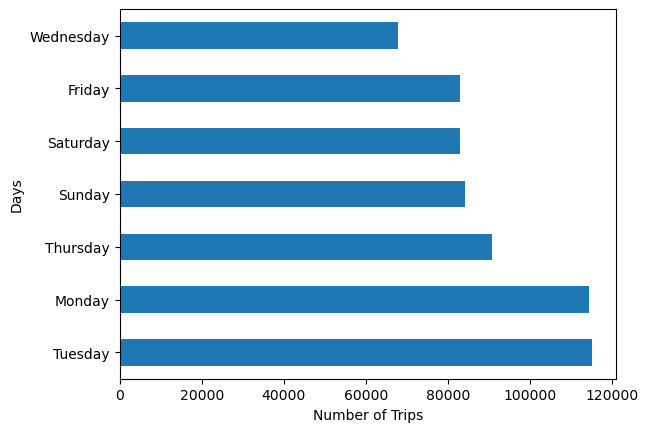

In [43]:
day_week = [calendar.day_name[x.dayofweek] for x in pd.to_datetime(data2['datetime'])]
day_week = pd.Series(day_week)
days = day_week.value_counts()
days.plot(kind='barh')
plt.xlabel('Number of Trips')
plt.ylabel('Days' )
plt.show()

/var/folders/gg/jytdm1894qg2n6n_rc94wb4w0000gn/T/ipykernel_54799/188549163.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, arrowstyle='->',


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

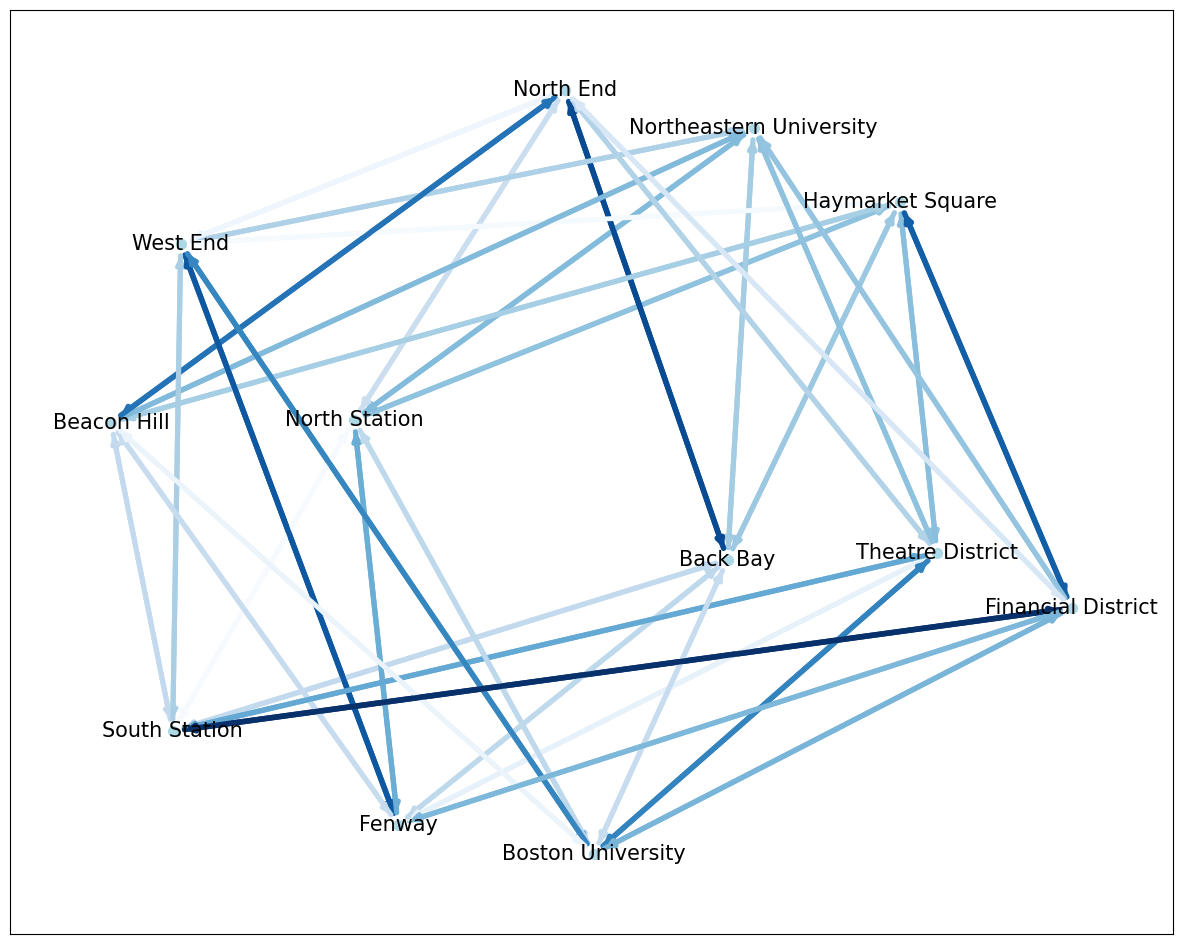

In [128]:
G = nx.DiGraph()

for idx, row in data2.iterrows():
    if G.has_edge(row['source'], row['destination']):
        # If the edge already exists, increase the weight
        G[row['source']][row['destination']]['weight'] += 1
    else:
        # Otherwise, add an edge with an initial weight of 1
        G.add_edge(row['source'], row['destination'], weight=1)

plt.figure(figsize=(15, 12))
pos = nx.kamada_kawai_layout(G, scale=2)  

# Adjust edge thickness based on weight
weights = [G[u][v]['weight'] for u, v in G.edges()]
edges = nx.draw_networkx_edges(G, pos, arrowstyle='->',
                               arrowsize=10, edge_color=weights,
                               edge_cmap=plt.cm.Blues,
                               width=4 * np.array(weights) / np.max(weights))

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=50)
nx.draw_networkx_labels(G, pos, font_size=15)

# Set colorbar
plt.colorbar(edges, label='Trip Frequency')
plt.title('Network Graph of Trips')
plt.axis('off')  
plt.show()

In [53]:
degree_dict = dict(g2.degree(G.nodes()))
nx.set_node_attributes(g2, degree_dict, 'degree')


in_degree_dict = dict(g2.in_degree(g2.nodes()))
out_degree_dict = dict(g2.out_degree(g2.nodes()))


print("Number of nodes:", g2.number_of_nodes())
print("Number of edges:", g2.number_of_edges())
print("Degree of nodes:", degree_dict)
print("In-degree of nodes:", in_degree_dict)
print("Out-degree of nodes:", out_degree_dict)

Number of nodes: 12
Number of edges: 72
Degree of nodes: {'Haymarket Square': 12, 'North Station': 12, 'Back Bay': 12, 'Northeastern University': 12, 'North End': 12, 'West End': 12, 'Beacon Hill': 12, 'South Station': 12, 'Fenway': 12, 'Theatre District': 12, 'Boston University': 12, 'Financial District': 12}
In-degree of nodes: {'Haymarket Square': 6, 'North Station': 6, 'Back Bay': 6, 'Northeastern University': 6, 'North End': 6, 'West End': 6, 'Beacon Hill': 6, 'South Station': 6, 'Fenway': 6, 'Theatre District': 6, 'Boston University': 6, 'Financial District': 6}
Out-degree of nodes: {'Haymarket Square': 6, 'North Station': 6, 'Back Bay': 6, 'Northeastern University': 6, 'North End': 6, 'West End': 6, 'Beacon Hill': 6, 'South Station': 6, 'Fenway': 6, 'Theatre District': 6, 'Boston University': 6, 'Financial District': 6}


In [55]:
label_encoder = preprocessing.LabelEncoder()
data2['id'] = label_encoder.fit_transform(data2['id'])
data2['datetime'] = label_encoder.fit_transform(data2['datetime'])
data2['timezone'] = label_encoder.fit_transform(data2['timezone'])
data2['destination'] = label_encoder.fit_transform(data2['destination'])
data2['product_id'] = label_encoder.fit_transform(data2['product_id'])
data2['short_summary'] = label_encoder.fit_transform(data2['short_summary'])
data2['long_summary'] = label_encoder.fit_transform(data2['long_summary'])
data2['name'] = label_encoder.fit_transform(data2['name'])

In [56]:
print("Class mapping of Name: ")
for i, item in enumerate(label_encoder.classes_):
    print(item, "-->", i)

Class mapping of Name: 
Black --> 0
Black SUV --> 1
Lux --> 2
Lux Black --> 3
Lux Black XL --> 4
Lyft --> 5
Lyft XL --> 6
Shared --> 7
UberPool --> 8
UberX --> 9
UberXL --> 10
WAV --> 11


In [57]:
data2['source'] = label_encoder.fit_transform(data2['source'])

print("Class mapping of Source: ")
for i, item in enumerate(label_encoder.classes_):
    print(item, "-->", i)

Class mapping of Source: 
Back Bay --> 0
Beacon Hill --> 1
Boston University --> 2
Fenway --> 3
Financial District --> 4
Haymarket Square --> 5
North End --> 6
North Station --> 7
Northeastern University --> 8
South Station --> 9
Theatre District --> 10
West End --> 11


In [58]:
data2['icon'] = label_encoder.fit_transform(data2['icon'])

print("Class mapping of Icon: ")
for i, item in enumerate(label_encoder.classes_):
    print(item, "-->", i)

Class mapping of Icon: 
 clear-day  --> 0
 clear-night  --> 1
 cloudy  --> 2
 fog  --> 3
 partly-cloudy-day  --> 4
 partly-cloudy-night  --> 5
 rain  --> 6


In [59]:
data2['cab_type'] = label_encoder.fit_transform(data2['cab_type'])

print("Class mapping of Cabe_type: ")
for i, item in enumerate(label_encoder.classes_):
    print(item, "-->", i)

Class mapping of Cabe_type: 
Lyft --> 0
Uber --> 1


In [60]:
len(data2[data2['cab_type']==1])

330568

In [61]:
x = data2[data2['cab_type']==1].drop(['price', 'cab_type'], axis=1)
y = data2[data2['cab_type']==1]['price']

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

In [70]:
def train_test_models(x_train, y_train, x_test, y_test):
    print("Linear Regression:")
    lr_model = LinearRegression()
    lr_model = lr_model.fit(x_train,  y_train)
    print(lr_model.score(x_test,  y_test))
    
    
    print("Decision Tree:")
    dt_model = DecisionTreeRegressor(random_state = 0, max_depth = 10)
    dt_model.fit(x_train,  y_train)
    print(dt_model.score(x_test,  y_test)) 
    
    
    print("Random Forest:")
    rf_model = RandomForestRegressor(n_estimators = 20, random_state = 0)
    rf_model.fit(x_train,  y_train)
    print(rf_model.score(x_test,  y_test)) 
    

    print("GBM:")
    gbm_model = ensemble.GradientBoostingRegressor(n_estimators = 200, max_depth = 5)
    gbm_model.fit(x_train,  y_train)
    print(gbm_model.score(x_test,  y_test)) 
    
    return [lr_model, dt_model, rf_model, gbm_model]

In [71]:
def feature_eliminate(trained_model, x, y, n_features=40):
    rfe = RFE(trained_model, n_features_to_select=n_features)
    rfe = rfe.fit(x, y)
    x_new = x[x.columns[rfe.support_]]
    x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.2, random_state = 0)
    new_fit = trained_model.fit(x_train, y_train)
    print(new_fit.score(x_test, y_test))

In [72]:
train_test_models(x_train, y_train, x_test, y_test)

Linear Regression:
0.6524591041659578
Decision Tree:
0.9485131391462979
Random Forest:
0.9419807235622679
GBM:
0.9519377821319098


[LinearRegression(),
 DecisionTreeRegressor(max_depth=10, random_state=0),
 RandomForestRegressor(n_estimators=20, random_state=0),
 GradientBoostingRegressor(max_depth=5, n_estimators=200)]

In [73]:
model_list = train_test_models(x_train, y_train, x_test, y_test)
n_features = [5, 10, 15, 20]

for model in model_list:
    for nf in n_features:
        print(f"{model} with {nf} features")
        feature_eliminate(model, x, y, nf)

Linear Regression:
0.6524591041659578
Decision Tree:
0.9485131391462979
Random Forest:
0.9419807235622679
GBM:
0.9519297078504598
LinearRegression() with 5 features
0.656421965729485
LinearRegression() with 10 features
0.6564572682689499
LinearRegression() with 15 features
0.6564359599010787
LinearRegression() with 20 features
0.656431031323877
DecisionTreeRegressor(max_depth=10, random_state=0) with 5 features
0.9519683669372733
DecisionTreeRegressor(max_depth=10, random_state=0) with 10 features
0.9505635280282637
DecisionTreeRegressor(max_depth=10, random_state=0) with 15 features
0.9500860411924364
DecisionTreeRegressor(max_depth=10, random_state=0) with 20 features
0.9498939749659479
RandomForestRegressor(n_estimators=20, random_state=0) with 5 features
0.9412401763032776
RandomForestRegressor(n_estimators=20, random_state=0) with 10 features
0.9437489531087625
RandomForestRegressor(n_estimators=20, random_state=0) with 15 features
0.943645779008615
RandomForestRegressor(n_estimat

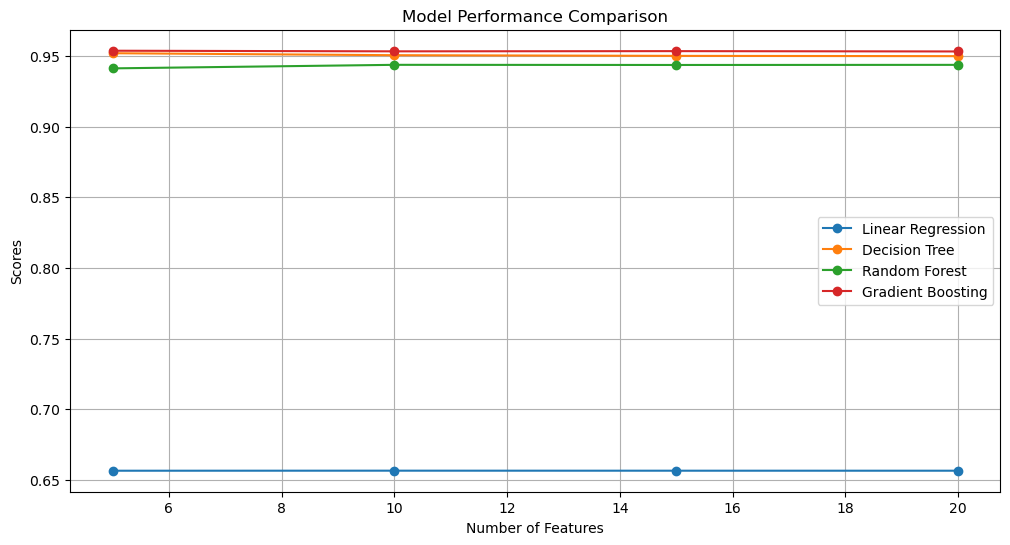

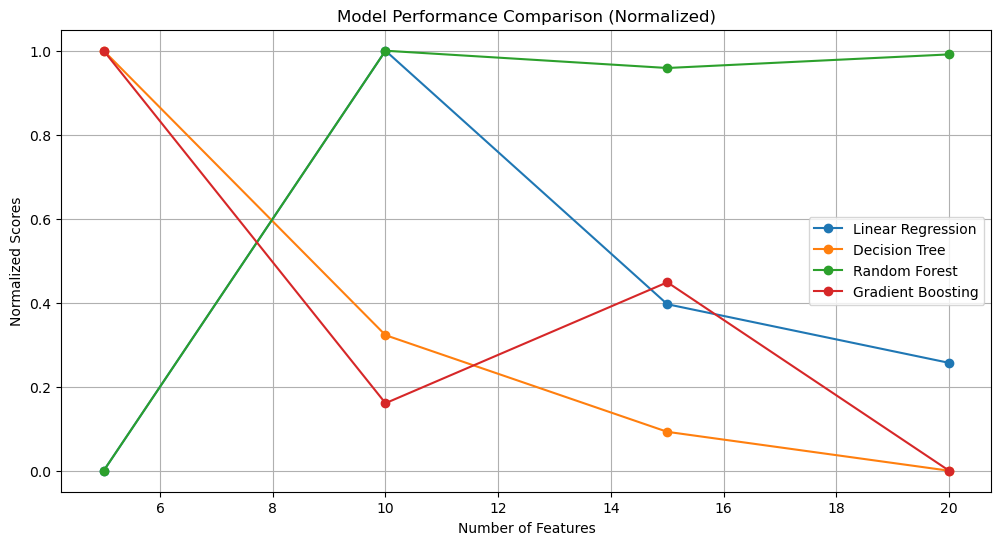

In [131]:
feature_counts = [5, 10, 15, 20]

linear_regression_scores = [
    0.656421965729485, 0.6564572682689499, 0.6564359599010787, 0.656431031323877
]

decision_tree_scores = [
    0.9519683669372733, 0.9505635280282637, 0.9500860411924364, 0.9498939749659479
]

random_forest_scores = [
    0.9412401763032776, 0.9437489531087625, 0.943645779008615, 0.9437269678478877
]

gradient_boosting_scores = [
    0.953733033297327, 0.9532963319512744, 0.953446133052296, 0.9532126826557752
]

plt.figure(figsize=(12, 6))
 

plt.plot(feature_counts, linear_regression_scores, marker='o', label='Linear Regression')
plt.plot(feature_counts, decision_tree_scores, marker='o', label='Decision Tree')
plt.plot(feature_counts, random_forest_scores, marker='o', label='Random Forest')
plt.plot(feature_counts, gradient_boosting_scores, marker='o', label='Gradient Boosting')

plt.title('Model Performance Comparison')
plt.xlabel('Number of Features')
plt.ylabel('Scores')  
plt.legend()
plt.grid(True)
plt.show()


# To facilitate comparison, normalized scores
def normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

linear_regression_scores_normalized = normalize(np.array(linear_regression_scores))
decision_tree_scores_normalized = normalize(np.array(decision_tree_scores))
random_forest_scores_normalized = normalize(np.array(random_forest_scores))
gradient_boosting_scores_normalized = normalize(np.array(gradient_boosting_scores))

plt.figure(figsize=(12, 6))

plt.plot(feature_counts, linear_regression_scores_normalized, marker='o', label='Linear Regression')
plt.plot(feature_counts, decision_tree_scores_normalized, marker='o', label='Decision Tree')
plt.plot(feature_counts, random_forest_scores_normalized, marker='o', label='Random Forest')
plt.plot(feature_counts, gradient_boosting_scores_normalized, marker='o', label='Gradient Boosting')

plt.title('Model Performance Comparison (Normalized)')
plt.xlabel('Number of Features')
plt.ylabel('Normalized Scores')

plt.legend()
plt.grid(True)
plt.show()
